# Flightanalysis

#### Load dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
from glob import glob

pd.set_option("display.max_columns", 500)

#plt.style.available -- to see the available style option for matlib
plt.style.use('seaborn-v0_8-dark-palette') # choice of style option

In [2]:
#Usage of parquet files because of higher decompression compared to csv
#findstr instead of grep because of missing UNIX env
%ls .\data\raw\ | findstr parquet 

07.10.2022  16:57       225.777.898 Combined_Flights_2018.parquet
07.10.2022  17:00       308.671.315 Combined_Flights_2019.parquet
07.10.2022  17:03       183.133.540 Combined_Flights_2020.parquet
07.10.2022  17:05       243.000.818 Combined_Flights_2021.parquet
07.10.2022  17:08       149.648.506 Combined_Flights_2022.parquet


In [3]:
#loading all parquet files into one list
parquet_files = glob("./data/raw/*.parquet")

In [4]:
#trying to trim down data cache needs by reducing number of columns
#and load data from parquet list into single dataframe
column_subset = [
             "FlightDate",
             "Airline",
             "IATA_Code_Marketing_Airline",
             "Flight_Number_Marketing_Airline",
             "IATA_Code_Operating_Airline",
             "Flight_Number_Operating_Airline",
             "Origin",
             "Dest",
             "OriginCityName",
             "DestCityName",
             "OriginState",
             "DestState",
             "Cancelled",
             "Diverted",
             "CRSDepTime",
             "DepTime",
             "DepDelayMinutes",
             "CRSArrTime",
             "ArrTime",
             "ArrDelayMinutes",              
]
dfs=[]
for f in parquet_files:
    dfs.append(
        pd.read_parquet(f, columns=column_subset)
    )
df = pd.concat(dfs).reset_index(drop=True)

In [5]:
# changing categorical data to the more efficient dtype "category" 
cat_cols = ['Airline', 'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline', 'Origin', 'Dest', 'OriginState', 'DestState']
for c in cat_cols:
    df[c] = df[c].astype("category")

In [6]:
# overview of dataframe
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 20 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   FlightDate                       datetime64[ns]
 1   Airline                          category      
 2   IATA_Code_Marketing_Airline      category      
 3   Flight_Number_Marketing_Airline  int64         
 4   IATA_Code_Operating_Airline      category      
 5   Flight_Number_Operating_Airline  int64         
 6   Origin                           category      
 7   Dest                             category      
 8   OriginCityName                   object        
 9   DestCityName                     object        
 10  OriginState                      category      
 11  DestState                        category      
 12  Cancelled                        bool          
 13  Diverted                         bool          
 14  CRSDepTime                      

,FlightDate,Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,IATA_Code_Operating_Airline,Flight_Number_Operating_Airline,Origin,Dest,OriginCityName,DestCityName,OriginState,DestState,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes
0,2018-01-23,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1157.0,0.0,1304,1256.0,0.0
1,2018-01-24,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1157.0,0.0,1304,1258.0,0.0
2,2018-01-25,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1153.0,0.0,1304,1302.0,0.0
3,2018-01-26,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1150.0,0.0,1304,1253.0,0.0
4,2018-01-27,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1400,1355.0,0.0,1500,1459.0,0.0


### Understanding the distribution of  _DelayMinutes_ for departure and arrival (+ the delta)

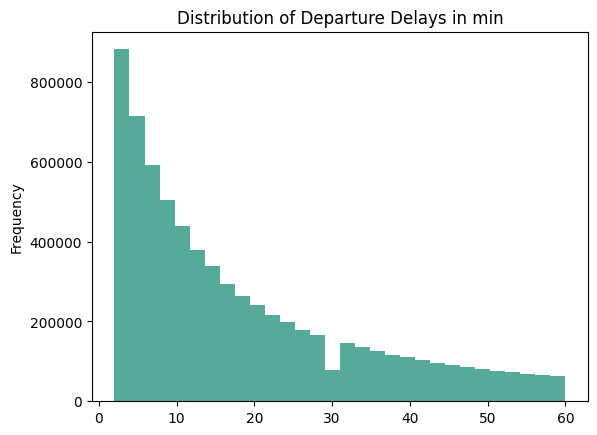

In [7]:
#distribution of departure delays between greater than 1 minute and less than 61 minutes
color = sns.color_palette("dark:#5A9_r")
df.query("DepDelayMinutes > 1 and DepDelayMinutes < 61")["DepDelayMinutes"].plot(kind="hist", bins=30, color=color, title='Distribution of Departure Delays in min')
plt.show()

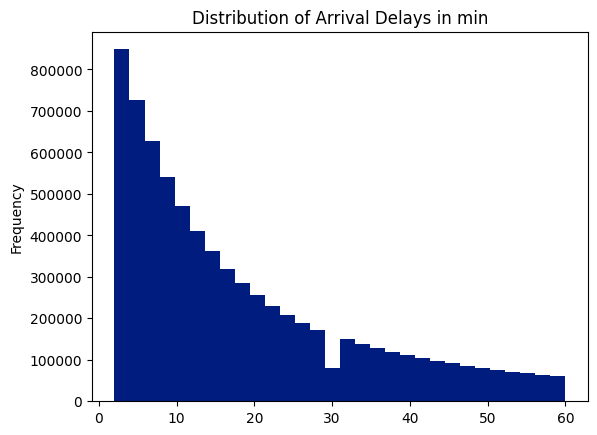

In [8]:
#distribution of arrival delays between greater than 1 minute and less than 61 minutes
df.query("ArrDelayMinutes > 1 and ArrDelayMinutes < 61")["ArrDelayMinutes"].plot(kind="hist", bins=30, title='Distribution of Arrival Delays in min')
plt.show()

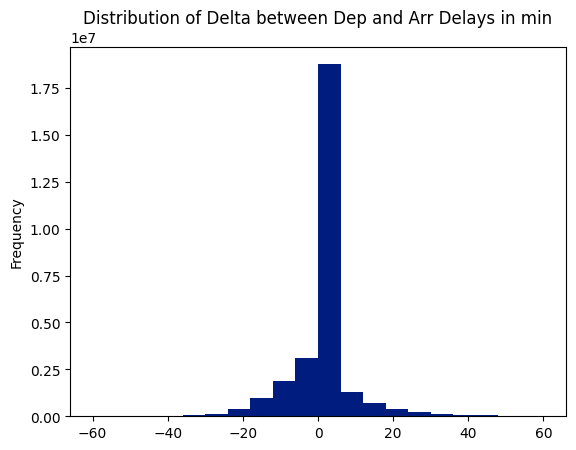

DeltaDelayMinutes
 0.0      16725777
-1.0        663263
-2.0        568753
-3.0        518635
 1.0        501070
            ...   
-139.0           1
 313.0           1
-162.0           1
-94.0            1
-110.0           1
Name: count, Length: 449, dtype: int64

In [9]:
#distribution of difference between departure and arrival delay between -61 minute and 61 minutes
df["DeltaDelayMinutes"] = df["ArrDelayMinutes"]-df["DepDelayMinutes"]
df.query("DeltaDelayMinutes > -61 and DeltaDelayMinutes < 61")["DeltaDelayMinutes"].plot(kind="hist", bins=20, title='Distribution of Delta between Dep and Arr Delays in min')
plt.show()
df["DeltaDelayMinutes"].value_counts()

### Adding data clusters

1. Following the industry guidelines the three main delay clusters are small (<=15min), medium (15-45minutes) and large delay (>45min)
2. Clustering the departuretime into 4 buckets a 6h, night (0:00-06:00), morning (6:00-12:00), afternoon (12:00-18:00), evening (18:00-24:00)
3. Clustering the departure states following the division mapping of the Census Bureau https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

In [10]:
df['DepDelayCluster'] = None
df.loc[df['DepDelayMinutes'] == 0, 'DepDelayCluster'] = 'OnTime_Early'
df.loc[(df['DepDelayMinutes'] > 0) & (df['DepDelayMinutes'] <= 15), 'DepDelayCluster'] = 'Small_Delay'
df.loc[(df['DepDelayMinutes'] > 15) & (df['DepDelayMinutes'] <= 45), 'DepDelayCluster'] = 'Medium_Delay'
df.loc[df['DepDelayMinutes'] > 45, 'DepDelayCluster'] = 'Large_Delay'
df.loc[df['Cancelled'], 'DepDelayCluster'] = 'Cancelled'

df['ArrDelayCluster'] = None
df.loc[df['ArrDelayMinutes'] == 0, 'ArrDelayCluster'] = 'OnTime_Early'
df.loc[(df['ArrDelayMinutes'] > 0) & (df['ArrDelayMinutes'] <= 15), 'ArrDelayCluster'] = 'Small_Delay'
df.loc[(df['ArrDelayMinutes'] > 15) & (df['ArrDelayMinutes'] <= 45), 'ArrDelayCluster'] = 'Medium_Delay'
df.loc[df['ArrDelayMinutes'] > 45, 'ArrDelayCluster'] = 'Large_Delay'
df.loc[df['Cancelled'], 'ArrDelayCluster'] = 'Cancelled'

df['DepTimeCluster'] = None
df.loc[df['CRSDepTime'] < 600, 'DepTimeCluster'] = 'Night'
df.loc[(df['CRSDepTime'] >= 600) & (df['CRSDepTime'] < 1200), 'DepTimeCluster'] = 'Morning'
df.loc[(df['CRSDepTime'] >= 1200) & (df['CRSDepTime'] < 1800), 'DepTimeCluster'] = 'Afternoon'
df.loc[df['CRSDepTime'] >= 1800, 'DepTimeCluster'] = 'Evening'

df['ArrTimeCluster'] = None
df.loc[df['CRSArrTime'] < 600, 'ArrTimeCluster'] = 'Night'
df.loc[(df['CRSArrTime'] >= 600) & (df['CRSArrTime'] < 1200), 'ArrTimeCluster'] = 'Morning'
df.loc[(df['CRSArrTime'] >= 1200) & (df['CRSArrTime'] < 1800), 'ArrTimeCluster'] = 'Afternoon'
df.loc[df['CRSArrTime'] >= 1800, 'ArrTimeCluster'] = 'Evening'

df['DepStateCluster'] = None
df.loc[(df['OriginState'] == 'CA') | (df['OriginState'] == 'OR') | (df['OriginState'] == 'WA')
       | (df['OriginState'] == 'AK') | (df['OriginState'] == 'HI')
       , 'DepStateCluster'] = 'Pacific'
df.loc[(df['OriginState'] == 'MT') | (df['OriginState'] == 'ID') | (df['OriginState'] == 'WY')
       | (df['OriginState'] == 'NV') | (df['OriginState'] == 'CO') | (df['OriginState'] == 'UT')
       | (df['OriginState'] == 'AZ') | (df['OriginState'] == 'NM')
       , 'DepStateCluster'] = 'Mountain'
df.loc[(df['OriginState'] == 'ND') | (df['OriginState'] == 'SD') | (df['OriginState'] == 'MN')
       | (df['OriginState'] == 'NE') | (df['OriginState'] == 'IA') | (df['OriginState'] == 'KS')
       | (df['OriginState'] == 'MO')
       , 'DepStateCluster'] = 'WestNorthCentral'
df.loc[(df['OriginState'] == 'WI') | (df['OriginState'] == 'MI') | (df['OriginState'] == 'IL')
       | (df['OriginState'] == 'IN') | (df['OriginState'] == 'OH')
       , 'DepStateCluster'] = 'EastNorthCentral'
df.loc[(df['OriginState'] == 'NY') | (df['OriginState'] == 'PA') | (df['OriginState'] == 'NJ')
       , 'DepStateCluster'] = 'MiddleAtlantic'
df.loc[(df['OriginState'] == 'VT') | (df['OriginState'] == 'NH') | (df['OriginState'] == 'ME')
       | (df['OriginState'] == 'MA') | (df['OriginState'] == 'CT') | (df['OriginState'] == 'RI')
       , 'DepStateCluster'] = 'NewEngland'
df.loc[(df['OriginState'] == 'OK') | (df['OriginState'] == 'TX') | (df['OriginState'] == 'LA')
       | (df['OriginState'] == 'AR')
       , 'DepStateCluster'] = 'WestSouthCentral'    
df.loc[(df['OriginState'] == 'KY') | (df['OriginState'] == 'TN') | (df['OriginState'] == 'MS')
       | (df['OriginState'] == 'AL')
       , 'DepStateCluster'] = 'EastSouthCentral'     
df.loc[(df['OriginState'] == 'WV') | (df['OriginState'] == 'MD') | (df['OriginState'] == 'DE')
       | (df['OriginState'] == 'DC') | (df['OriginState'] == 'VA') | (df['OriginState'] == 'DE') 
       | (df['OriginState'] == 'NC') | (df['OriginState'] == 'SC') | (df['OriginState'] == 'GA')
       | (df['OriginState'] == 'FL')
       , 'DepStateCluster'] = 'SouthAtlantic' 

df['ArrStateCluster'] = None
df.loc[(df['DestState'] == 'CA') | (df['DestState'] == 'OR') | (df['DestState'] == 'WA')
       | (df['DestState'] == 'AK') | (df['DestState'] == 'HI')
       , 'ArrStateCluster'] = 'Pacific'
df.loc[(df['DestState'] == 'MT') | (df['DestState'] == 'ID') | (df['DestState'] == 'WY')
       | (df['DestState'] == 'NV') | (df['DestState'] == 'CO') | (df['DestState'] == 'UT')
       | (df['DestState'] == 'AZ') | (df['DestState'] == 'NM')
       , 'ArrStateCluster'] = 'Mountain'
df.loc[(df['DestState'] == 'ND') | (df['DestState'] == 'SD') | (df['DestState'] == 'MN')
       | (df['DestState'] == 'NE') | (df['DestState'] == 'IA') | (df['DestState'] == 'KS')
       | (df['DestState'] == 'MO')
       , 'ArrStateCluster'] = 'WestNorthCentral'
df.loc[(df['DestState'] == 'WI') | (df['DestState'] == 'MI') | (df['DestState'] == 'IL')
       | (df['DestState'] == 'IN') | (df['DestState'] == 'OH')
       , 'ArrStateCluster'] = 'EastNorthCentral'
df.loc[(df['DestState'] == 'NY') | (df['DestState'] == 'PA') | (df['DestState'] == 'NJ')
       , 'ArrStateCluster'] = 'MiddleAtlantic'
df.loc[(df['DestState'] == 'VT') | (df['DestState'] == 'NH') | (df['DestState'] == 'ME')
       | (df['DestState'] == 'MA') | (df['DestState'] == 'CT') | (df['DestState'] == 'RI')
       , 'ArrStateCluster'] = 'NewEngland'
df.loc[(df['DestState'] == 'OK') | (df['DestState'] == 'TX') | (df['DestState'] == 'LA')
       | (df['DestState'] == 'AR')
       , 'ArrStateCluster'] = 'WestSouthCentral'    
df.loc[(df['DestState'] == 'KY') | (df['DestState'] == 'TN') | (df['DestState'] == 'MS')
       | (df['DestState'] == 'AL')
       , 'ArrStateCluster'] = 'EastSouthCentral'     
df.loc[(df['DestState'] == 'WV') | (df['DestState'] == 'MD') | (df['DestState'] == 'DE')
       | (df['DestState'] == 'DC') | (df['DestState'] == 'VA') | (df['DestState'] == 'DE') 
       | (df['DestState'] == 'NC') | (df['DestState'] == 'SC') | (df['DestState'] == 'GA')
       | (df['DestState'] == 'FL')
       , 'ArrStateCluster'] = 'SouthAtlantic' 


df.head(5)

,FlightDate,Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,IATA_Code_Operating_Airline,Flight_Number_Operating_Airline,Origin,Dest,OriginCityName,DestCityName,OriginState,DestState,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,DeltaDelayMinutes,DepDelayCluster,ArrDelayCluster,DepTimeCluster,ArrTimeCluster,DepStateCluster,ArrStateCluster
0,2018-01-23,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1157.0,0.0,1304,1256.0,0.0,0.0,OnTime_Early,OnTime_Early,Afternoon,Afternoon,SouthAtlantic,SouthAtlantic
1,2018-01-24,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1157.0,0.0,1304,1258.0,0.0,0.0,OnTime_Early,OnTime_Early,Afternoon,Afternoon,SouthAtlantic,SouthAtlantic
2,2018-01-25,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1153.0,0.0,1304,1302.0,0.0,0.0,OnTime_Early,OnTime_Early,Afternoon,Afternoon,SouthAtlantic,SouthAtlantic
3,2018-01-26,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1202,1150.0,0.0,1304,1253.0,0.0,0.0,OnTime_Early,OnTime_Early,Afternoon,Afternoon,SouthAtlantic,SouthAtlantic
4,2018-01-27,Endeavor Air Inc.,DL,3298,9E,3298,ABY,ATL,"Albany, GA","Atlanta, GA",GA,GA,False,False,1400,1355.0,0.0,1500,1459.0,0.0,0.0,OnTime_Early,OnTime_Early,Afternoon,Afternoon,SouthAtlantic,SouthAtlantic


In [11]:
color = sns.color_palette("dark:#5A9_r")
#color = ['black', 'dimgray', 'dimgrey', 'gray', 'grey']
df['Year'] = df['FlightDate'].dt.year
df['Month'] = df['FlightDate'].dt.month


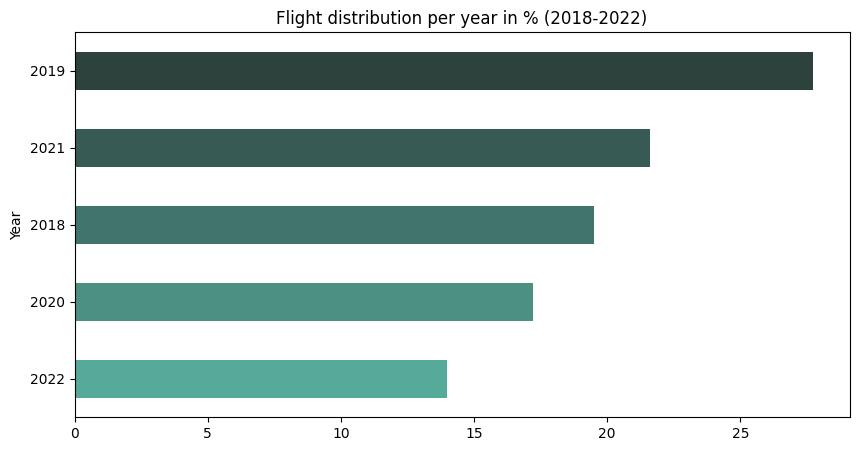

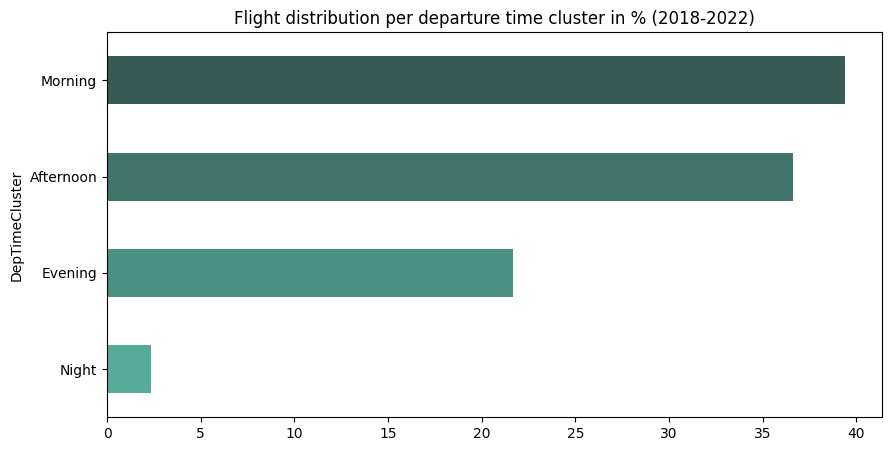

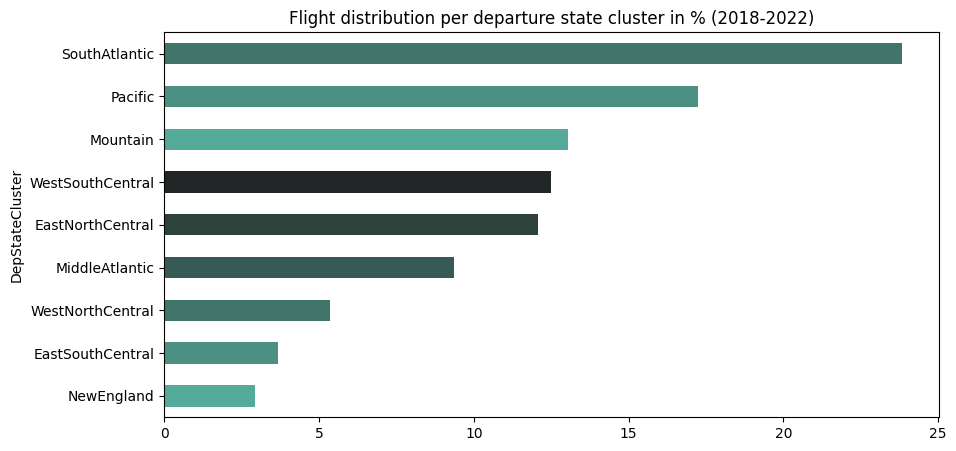

In [12]:
(df["Year"].value_counts(normalize=True,ascending=True)*100).plot(
    kind="barh", figsize=(10, 5), color=color, title="Flight distribution per year in % (2018-2022)"
)
plt.show()

(df["DepTimeCluster"].value_counts(normalize=True,ascending=True)*100).plot(
    kind="barh", figsize=(10, 5), color=color, title="Flight distribution per departure time cluster in % (2018-2022)"
)
plt.show()

(df["DepStateCluster"].value_counts(normalize=True,ascending=True)*100).plot(
    kind="barh", figsize=(10, 5), color=color, title="Flight distribution per departure state cluster in % (2018-2022)"
)
plt.show()

### Distribution of the Delay Clusters
1. Overall
2. per Year
3. per Month
4. per Departure Time Cluster
5. per State Cluster

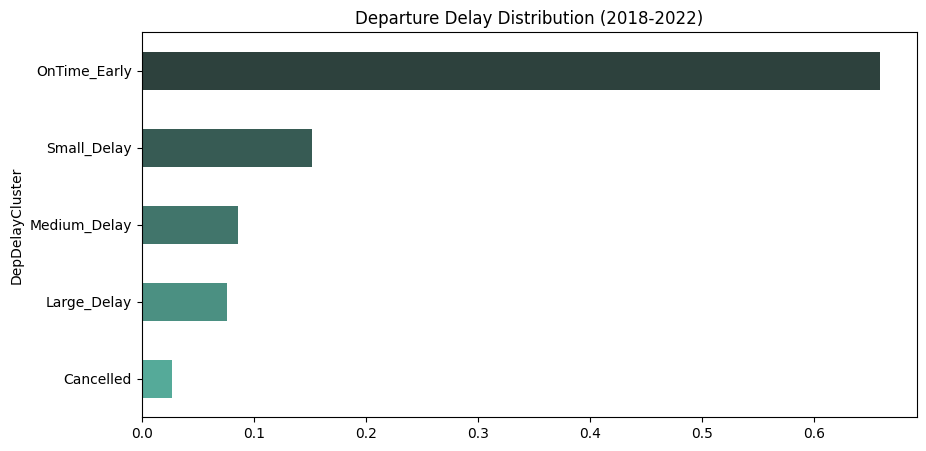

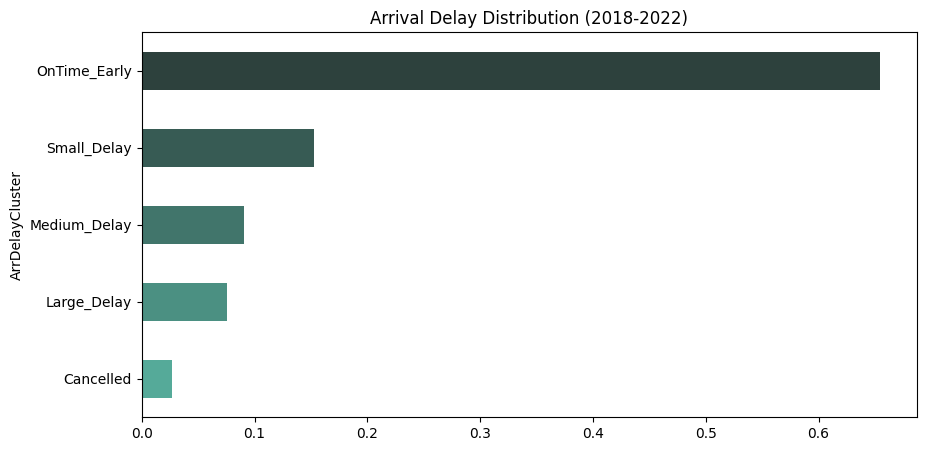

In [13]:
df["DepDelayCluster"].value_counts(normalize=True,ascending=True).plot(
    kind="barh", figsize=(10, 5), color=color, title="Departure Delay Distribution (2018-2022)"
)
plt.show()

df["ArrDelayCluster"].value_counts(normalize=True,ascending=True).plot(
    kind="barh", figsize=(10, 5), color=color, title="Arrival Delay Distribution (2018-2022)"
)
plt.show()

In [14]:
#predefined column order, that sorts the cluster more logical (ascending in seriousness)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

In [15]:
title = "Departure Delays per year (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = df.groupby('Year')["DepDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Greys').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.115615,16.474583,9.538448,8.317789,1.553565
2019,64.619787,15.716778,9.081583,8.683248,1.898604
2020,76.052291,9.653418,4.572319,3.727722,5.994249
2021,65.698142,16.145308,8.917879,7.479795,1.758876
2022,58.801153,17.706368,10.926539,9.545283,3.020657


In [16]:
title = "Departure Delays per month (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per month (the groupby) 
df_agg_year_cluster = df.groupby('Month')["DepDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Blues').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,68.169907,13.961832,7.878093,7.008976,2.981192
2,64.960611,15.300969,8.828322,7.786858,3.123240
3,66.363322,14.172305,7.716007,6.173113,5.575252
4,64.436275,14.051844,7.824258,6.853866,6.833756
5,65.023841,16.224252,8.965554,7.875154,1.911198
6,59.488265,17.349791,10.754222,10.442093,1.965629
7,61.996702,16.361900,10.052315,9.906083,1.683000
8,64.622096,15.009025,9.096512,9.137345,2.135022
9,72.924881,13.140776,6.725733,5.813787,1.394822


In [17]:
title = "Departure Delays per TimeCluster (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = df.groupby('DepTimeCluster')["DepDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Reds').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
DepTimeCluster,,,,,
Afternoon,61.911200,16.775136,10.004965,8.659309,2.649389
Evening,56.955393,16.541578,12.087370,11.374873,3.040785
Morning,73.857067,13.191309,5.696116,4.808278,2.447230
Night,77.336592,11.652809,4.029450,3.989103,2.992045


In [18]:
title = "Departure Delays per StateCluster (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = df.groupby('DepStateCluster')["DepDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Greens').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
DepStateCluster,,,,,
EastNorthCentral,66.844962,13.758853,8.284145,8.168198,2.943842
EastSouthCentral,68.153852,13.597411,7.956732,7.508748,2.783258
MiddleAtlantic,66.679002,12.160104,8.228436,9.355295,3.577163
Mountain,63.072956,17.577198,9.537804,7.549248,2.262793
NewEngland,66.807647,13.241002,7.972232,8.721383,3.257736
Pacific,67.169933,16.653926,8.238006,5.892478,2.045657
SouthAtlantic,65.871196,15.024091,8.716212,7.788881,2.599620
WestNorthCentral,69.644334,13.586116,7.386444,6.785923,2.597183
WestSouthCentral,63.301222,16.300108,9.423477,7.986958,2.988235


In [19]:
title = "Arrival Delays per year (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = df.groupby('Year')["ArrDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Greys').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

ArrDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,63.015684,16.921381,10.132155,8.373545,1.557236
2019,64.183592,15.613390,9.611452,8.688072,1.903494
2020,73.378141,11.664195,5.311643,3.641714,6.004306
2021,66.165985,15.721131,9.089331,7.260491,1.763061
2022,60.351839,16.312473,10.894401,9.413049,3.028238


In [20]:
title = "Arrival Delays per month (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per month (the groupby) 
df_agg_year_cluster = df.groupby('Month')["ArrDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Blues').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

ArrDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,67.697622,14.038633,8.383413,6.893250,2.987082
2,64.125505,15.134913,9.703993,7.905272,3.130317
3,66.030416,14.332729,8.050296,6.001549,5.585010
4,64.211554,14.132840,8.074142,6.734792,6.846671
5,65.686202,15.554386,9.063976,7.778956,1.916481
6,60.207890,16.532778,10.855146,10.432177,1.972008
7,62.260932,15.944794,10.230353,9.875396,1.688525
8,63.611486,15.415349,9.602038,9.229653,2.141474
9,71.607407,14.022163,7.217382,5.755493,1.397554


In [21]:
title = "Arrival Delays per TimeCluster (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = df.groupby('ArrTimeCluster')["ArrDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Reds').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

ArrDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
ArrTimeCluster,,,,,
Afternoon,66.155833,15.464609,8.878590,7.021718,2.479251
Evening,59.190802,15.839470,11.398332,10.629000,2.942396
Morning,72.350012,14.426879,6.234978,4.398803,2.589329
Night,58.445574,16.010197,12.172475,10.589804,2.781950


In [22]:
title = "Arrival Delays per StateCluster (in %)"

#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = df.groupby('ArrStateCluster')["ArrDelayCluster"].value_counts(normalize=True).unstack()

(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Greens').set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px')
    ]
}])

ArrDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
ArrStateCluster,,,,,
EastNorthCentral,66.453681,14.164834,8.389625,8.007588,2.984272
EastSouthCentral,65.037606,15.174102,9.232045,7.850182,2.706066
MiddleAtlantic,63.026107,13.449111,9.578753,10.347451,3.598578
Mountain,65.520173,16.247693,9.029745,6.930341,2.272048
NewEngland,63.761165,13.845205,9.400968,9.799835,3.192826
Pacific,65.678623,16.894543,9.255091,6.120585,2.051158
SouthAtlantic,66.476576,14.801894,8.744870,7.364255,2.612405
WestNorthCentral,67.758357,14.479744,8.314729,6.919483,2.527688
WestSouthCentral,63.567395,16.268896,9.590482,7.554998,3.018230


## Delay Cluster Comparisons for Airlines and Airports
- Most delays?
- Most cancellations?
- Most onTime?

#### Flight Distribution by Airline

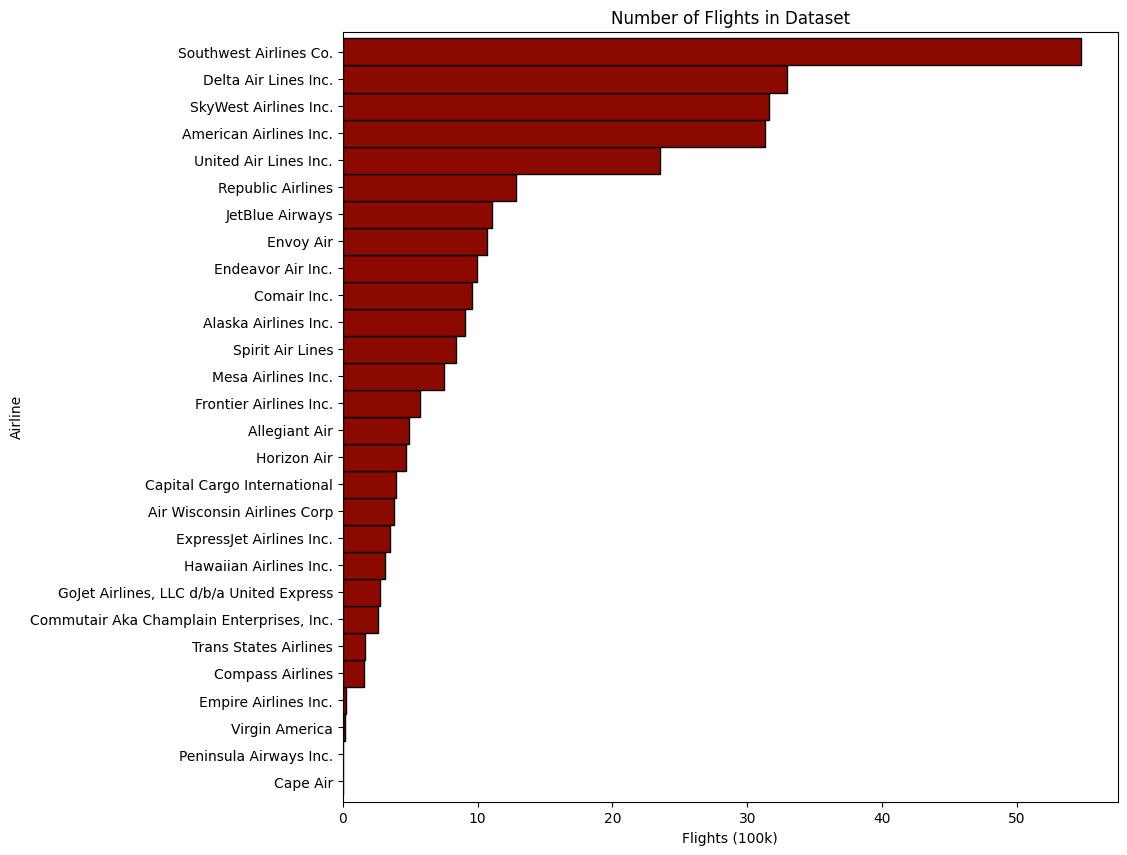

In [23]:
pal = sns.color_palette()
fig, ax = plt.subplots(figsize=(10, 10))
airlines_ordered = (df["Airline"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")
plt.show()

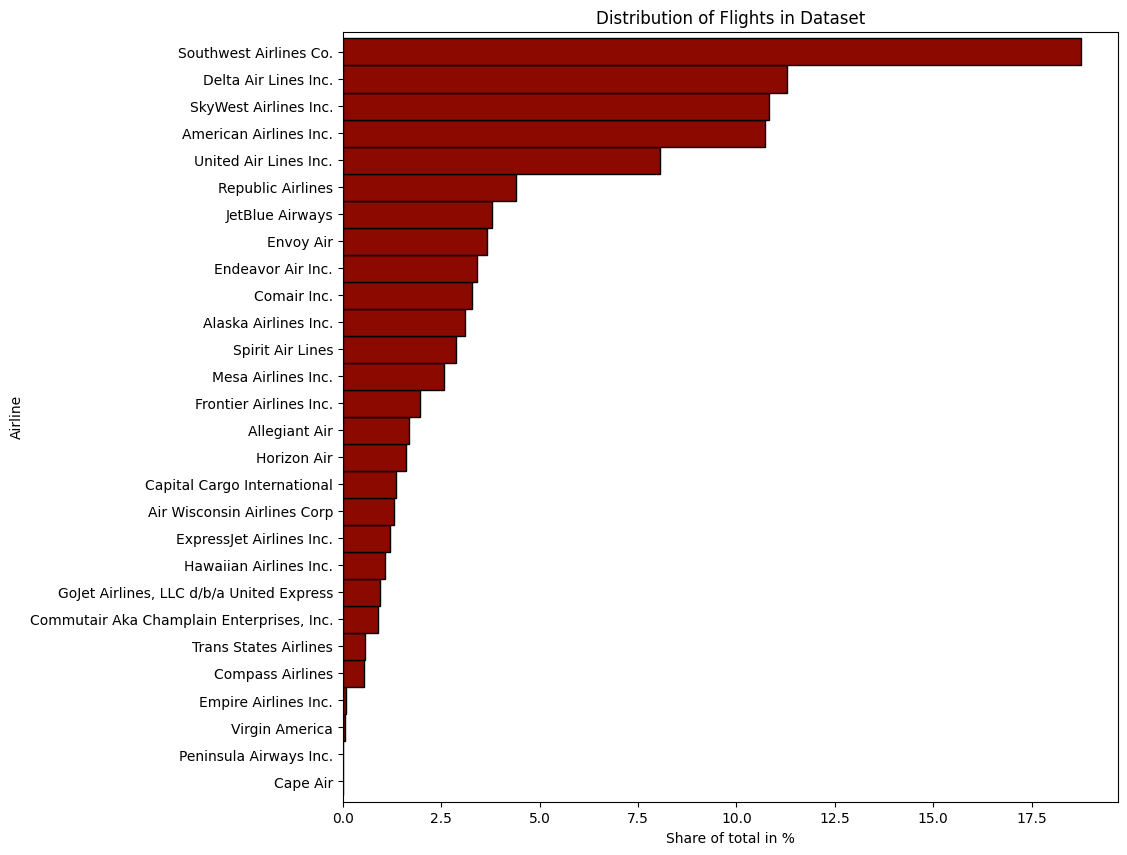

In [24]:
pal = sns.color_palette()
fig, ax = plt.subplots(figsize=(10, 10))
airlines_ordered = (df["Airline"].value_counts(normalize=True,ascending=True).mul(100)).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black", mouseover=True
)
ax.set_title("Distribution of Flights in Dataset")
ax.set_xlabel("Share of total in %")
plt.show()

In [25]:
#creating a list of the top airlines (based on >1m flights in dataset) and filtering a copy of the dataframe 
top_airlines = (
    df["Airline"]
    .value_counts()
    .reset_index()
).query("count > 1_000_000",engine = 'python')["Airline"].values.tolist()
df_top_airline = df.loc[df["Airline"].isin(top_airlines)].reset_index(drop=True).copy()
#reseting the airline category to be sure to only include airlines from the created list
df_top_airline["Airline"] = df_top_airline["Airline"].astype("str").astype("category")

<ipython-input-26-e26a2c997568>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_airline.groupby(["Airline"])["DepDelayCluster"]


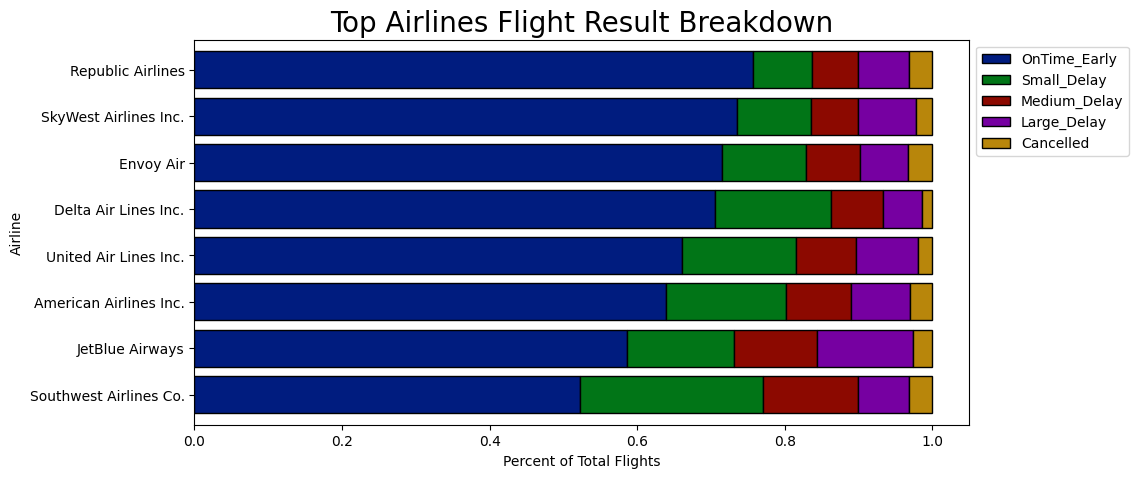

In [26]:
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top_airline.groupby(["Airline"])["DepDelayCluster"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

#### Simplification of the DelayCluster by binary "Good"/"Bad" aggregation

In [27]:
delay_mapping = {
    "OnTime_Early": "Good",
    "Small_Delay": "Good",
    "Medium_Delay": "Bad",
    "Large_Delay": "Bad",
    "Cancelled": "Bad",
}

<ipython-input-28-52d8bbc11a26>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_airline.groupby(["Airline"])["DelayOk"]


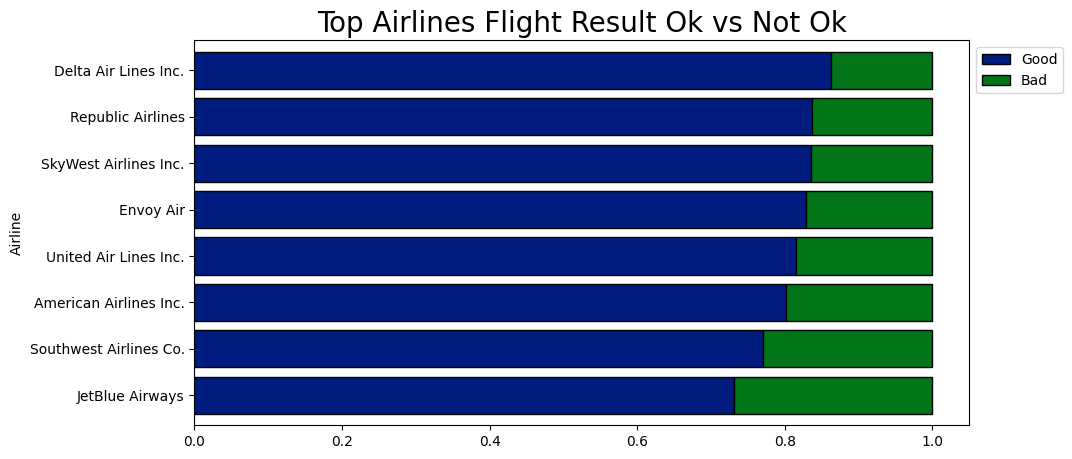

In [28]:
df_top_airline["DelayOk"] = df_top_airline["DepDelayCluster"].map(delay_mapping)

df_agg = (
    df_top_airline.groupby(["Airline"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()

#### Flight Distribution by Airport

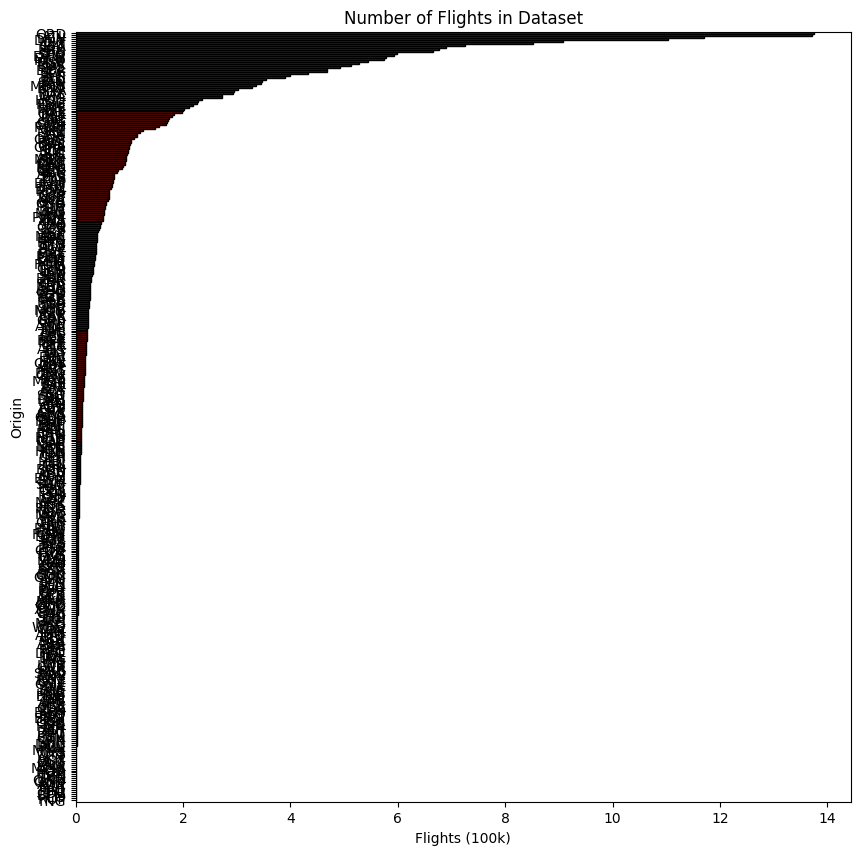

In [29]:
pal = sns.color_palette()
fig, ax = plt.subplots(figsize=(10, 10))
airports_ordered = (df["Origin"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")
plt.show()

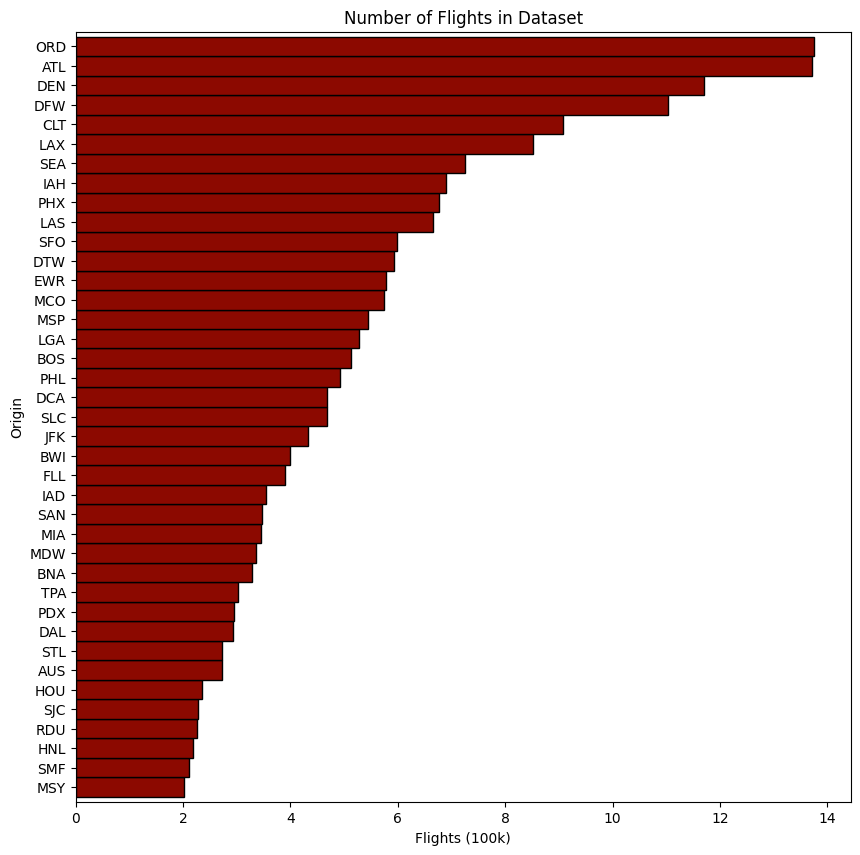

In [30]:
#reduced distribution to minimum 200k departures (top airline list approach see above)
top_airport = (
    df["Origin"]
    .value_counts()
    .reset_index()
).query("count > 200_000",engine = 'python')["Origin"].values.tolist()
df_top_airport = df.loc[df["Origin"].isin(top_airport)].reset_index(drop=True).copy()

df_top_airport["Origin"] = df_top_airport["Origin"].astype("str").astype("category")
pal = sns.color_palette()
fig, ax = plt.subplots(figsize=(10, 10))
airports_ordered = (df_top_airport["Origin"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")
plt.show()



<ipython-input-31-bb7f1cba97d7>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_airport.groupby(["Origin"])["DepDelayCluster"]


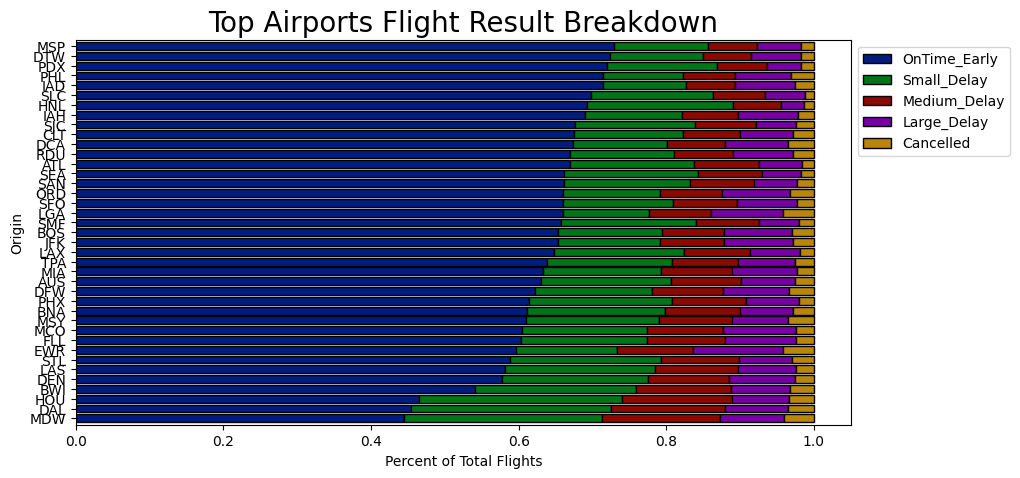

In [31]:
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top_airport.groupby(["Origin"])["DepDelayCluster"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airports Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

<ipython-input-39-94b2b936d25d>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_airport.groupby(["Origin"])["DelayOk"]


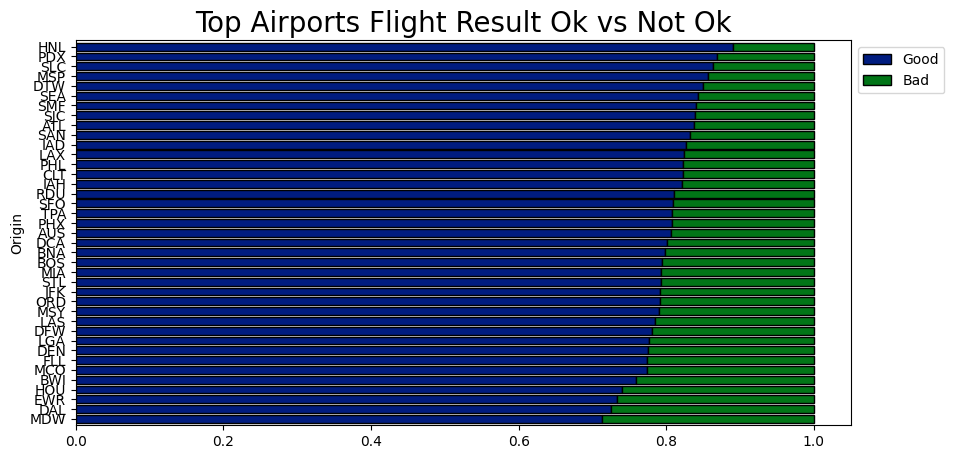

In [39]:
df_top_airport["DelayOk"] = df_top_airport["DepDelayCluster"].map(delay_mapping)

df_agg = (
    df_top_airport.groupby(["Origin"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airports Flight Result Ok vs Not Ok", fontsize=20)

plt.show()

### Deepdive: what was the impact of Covid on Cancellations and Delays?
1.Excluding 2020 from the monthly distribution to find 

In [33]:
#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = (
    df.query("3 <= Month <= 4")
    .groupby('Year')["DepDelayCluster"]
    .value_counts(normalize=True)
    .unstack()
)
#predefined column order, that sorts the cluster more logical (ascending in seriousness)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Oranges') 

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.219260,17.194531,9.582907,7.347652,1.655651
2019,65.790141,15.462990,8.614418,7.974924,2.157527
2020,63.063286,6.202543,3.291875,2.733237,24.709059
2021,76.291254,13.015721,5.715776,4.077733,0.899516
2022,59.301505,18.234213,11.096981,9.445164,1.922137


In [34]:
#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = (
    df.query("3 <= Month <= 4")
    .groupby('Year')["ArrDelayCluster"]
    .value_counts(normalize=True)
    .unstack()
)
#predefined column order, that sorts the cluster more logical (ascending in seriousness)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Oranges') 

ArrDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,63.877458,17.322283,9.883198,7.258841,1.658221
2019,65.633106,15.485992,8.951204,7.767798,2.161900
2020,61.236452,7.708359,3.742187,2.575432,24.737570
2021,75.926594,13.305425,5.971544,3.895415,0.901022
2022,60.346896,17.120207,11.235069,9.370963,1.926866


In [35]:
#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = (
    df.query("Year != 2020")
    .groupby('Month')["DepDelayCluster"]
    .value_counts(normalize=True)
    .unstack()
)
#predefined column order, that sorts the cluster more logical (ascending in seriousness)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Blues') 

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,67.162457,13.880797,8.068641,7.353867,3.534239
2,62.623134,15.912800,9.424684,8.139587,3.899795
3,65.869000,16.332230,8.904784,7.101697,1.792290
4,66.161402,15.715543,8.783821,7.685515,1.653719
5,63.468665,17.070321,9.537899,8.407955,1.515159
6,56.855480,18.188167,11.525967,11.298683,2.131703
7,58.511717,17.645319,11.048691,10.968325,1.825949
8,60.348823,16.490201,10.289753,10.508081,2.363141
9,70.637088,14.016242,7.374660,6.454308,1.517702


In [36]:
#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = (
    df.query("Year != 2020")
    .groupby('Month')["ArrDelayCluster"]
    .value_counts(normalize=True)
    .unstack()
)
#predefined column order, that sorts the cluster more logical (ascending in seriousness)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Blues') 

ArrDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,66.433473,14.157799,8.595508,7.271977,3.541243
2,61.674243,15.694539,10.374794,8.347277,3.909148
3,66.154990,15.970645,9.156952,6.921686,1.795728
4,66.066679,15.652615,9.046301,7.577328,1.657077
5,64.236711,16.272794,9.646345,8.324692,1.519457
6,57.832843,17.123625,11.603257,11.301268,2.139008
7,59.574380,16.574315,11.109823,10.909256,1.832227
8,60.024021,16.283927,10.709329,10.611995,2.370727
9,69.577432,14.626312,7.869751,6.405670,1.520836


In [37]:
#the normalize=True will return the relative frequencies (share of total) of the unique values, 
#in this case cluster per year (the groupby) 
df_agg_year_cluster = (
    df.query("Year == 2020")
    .groupby('Month')["DepDelayCluster"]
    .value_counts(normalize=True)
    .unstack()
)
#predefined column order, that sorts the cluster more logical (ascending in seriousness)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
(df_agg_year_cluster * 100)[col_order].style.background_gradient(cmap='Blues') 

DepDelayCluster,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,71.279649,14.211967,7.289919,5.944386,1.274078
2,71.417406,13.610912,7.180996,6.812517,0.978169
3,67.838676,7.725796,4.167986,3.401666,16.865876
4,52.953164,2.977617,1.437033,1.318085,41.314100
5,82.541629,6.693969,2.518554,1.873584,6.372264
6,83.767449,9.618400,3.637299,2.542737,0.434116
7,83.792223,8.335243,3.820859,3.262696,0.788979
8,84.274851,8.197104,3.608804,2.833338,1.085904
9,85.289927,8.409066,3.218417,2.351909,0.730682


### Additional Analysis: Using _cmap_ to build a distribution map for cancellations per weekdays to months and years

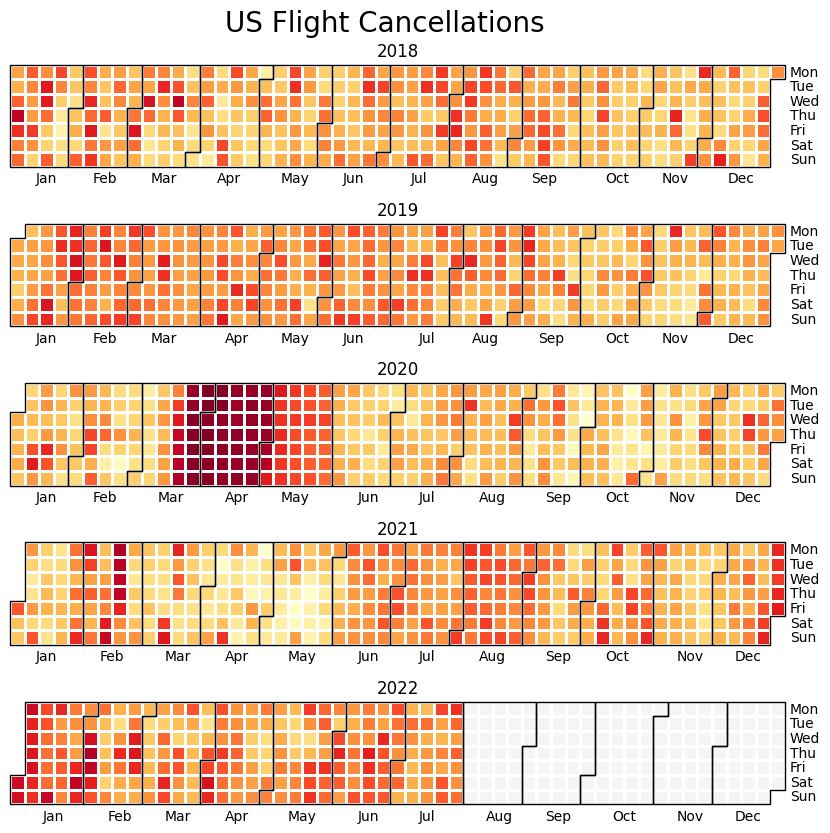

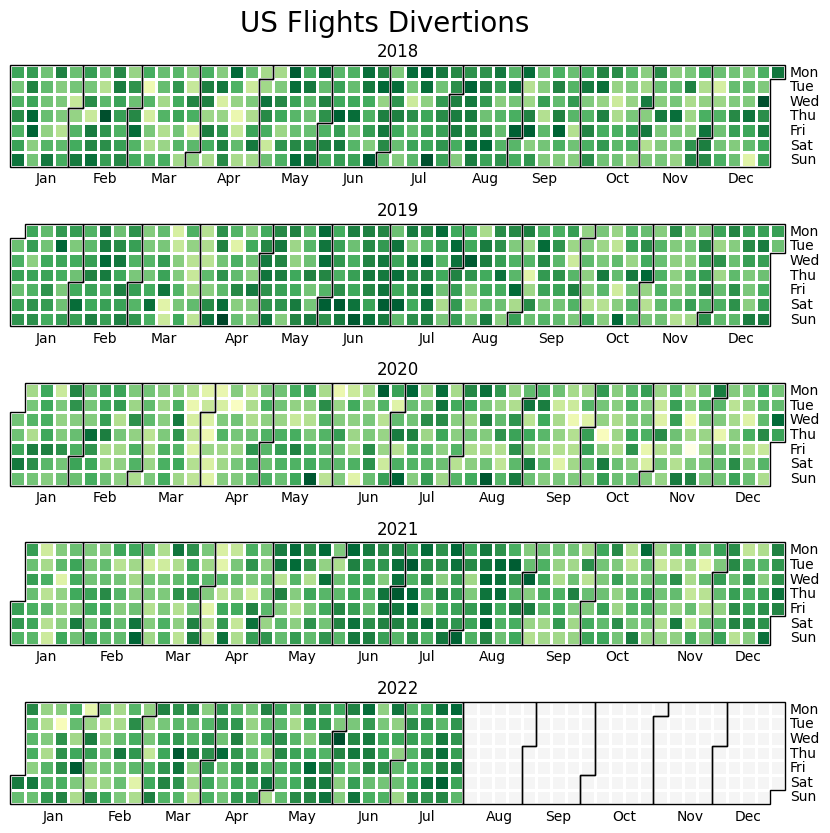

In [38]:
import calmap
events = df.groupby("FlightDate")["Cancelled"].mean()
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(
        events.apply(np.log), year=year, cmap="YlOrRd", monthly_border=True, ax=axs[i]
    )
    axs[i].set_title(year)
fig.patch.set_facecolor("white")
fig.suptitle("US Flight Cancellations", y=0.92, fontsize=20)
plt.show()

events = df.groupby("FlightDate")["Diverted"].mean()
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(
        events.apply(np.log), year=year, cmap="YlGn", monthly_border=True, ax=axs[i]
    )
    axs[i].set_title(year)
fig.patch.set_facecolor("white")
fig.suptitle("US Flights Divertions", y=0.92, fontsize=20)
plt.show()

## Conclusion:
1. JetBlue Airways seems to be the worst performing Airline of the chosen Airlines (>1m Flights)
2. Chicago Midway International Airport seems to be the worst performing Airport of the chosen Airports (>200k Departures)
3. Delta Airlines seems to be the best performing Airline in the chosen Airlines (>1m Flights)
4. Honululu International Airport seems to be the best performing Airport of the chosen Airports (>200k Departures)
5. The overall performance of Airlines and Airports seems to be good (>70% "good" Departures)

### For discussion: 
- Should 2020 be excluded because of the above average cancellation rate through the impact of Covid?
- What Cancellation Cluster should be chosen to represent performance (Dep../Arr..)?
### Further Analysis:
- Deepdive and Comparison of the Delta between Departure and Arrival Delay Minutes -> Which Airline is able to reduce the departure delay on what route the most?